In [195]:
import seaborn as sns
sns.set_theme()

In [196]:
# Calculate the similarity between the anomaly datasets and the baseline data.
# Each dataset will be loaded into its own Pandas dataframe.

import pandas as pd
import numpy as np
from scipy import stats

from qdrant_client import QdrantClient

q_client = QdrantClient("localhost", port=6333)

def round_to_nearest(x, base):
    return base * round(x/base)

def load_collection(col_name, error_type_ids, with_similarity=True):
    baseline_col_name = "baseline"
    live_points = q_client.scroll(collection_name=col_name, limit=1000, with_vectors=True)

    data = []

    # Calculate similarity to baseline
    for p in live_points[0]:
        scores = [0]
        if with_similarity:
            search_result = q_client.search(
                collection_name=baseline_col_name,
                query_vector=p.vector,
                limit=10
            )

            scores = [s.score for s in search_result]

        record = {
            'anomaly': col_name,
            'country': p.payload['country'],
            'duration_ms': p.payload['duration'],
            'duration_bin': round_to_nearest(p.payload['duration'], 50),
            'http_req_method': p.payload['http.request.method'],
            'http_res_status_code': p.payload['http.response.status_code'],
            'max_similarity': max(scores)
        }

        if 'forecast.temperatureC' in p.payload:
            record['forecast_temperature_c'] = p.payload['forecast.temperatureC']
            record['forecast_temperature_c_bin'] = round_to_nearest(p.payload['forecast.temperatureC'], 10)

        if 'error.type' in p.payload:
            error_type = p.payload['error.type']
            
            if error_type not in error_type_ids:
                error_type_ids[error_type] = len(error_type_ids)

            record['error_type'] = error_type
            record['error_type_id'] = error_type_ids[error_type]
        else:
            record['error_type_id'] = -1

        data.append(record)

    # z-score (how many standard deviations is the max_similarity (closest point) away from the mean?)
    df = pd.DataFrame.from_records(data)
    df['max_similarity_z_score'] = np.abs(stats.zscore(df['max_similarity']))

    return df

error_type_ids = {}
baseline_df = load_collection("baseline", error_type_ids, with_similarity=False)
live_brazil_df = load_collection("live_add_brazil", error_type_ids)
live_high_uk_latency_df = load_collection("live_high_uk_latency", error_type_ids)
live_unseen_exception_type_df = load_collection("live_unseen_exception_type", error_type_ids)

all_data = pd.concat([live_brazil_df, live_high_uk_latency_df, live_unseen_exception_type_df])

all_data

,anomaly,country,duration_ms,duration_bin,http_req_method,http_res_status_code,max_similarity,forecast_temperature_c,forecast_temperature_c_bin,error_type_id,error_type,max_similarity_z_score
0,live_add_brazil,UK,321.5353,300,GET,200,0.999931,17.0,20.0,-1,NaN,0.708476
1,live_add_brazil,Brazil,1410.9826,1400,GET,500,0.999109,39.0,40.0,0,System.Collections.Generic.KeyNotFoundException,0.403942
2,live_add_brazil,Brazil,511.3224,500,GET,200,0.993974,21.0,20.0,-1,NaN,1.498690
3,live_add_brazil,Brazil,368.1640,350,GET,200,0.994446,20.0,20.0,-1,NaN,1.323824
4,live_add_brazil,UK,421.9901,400,GET,200,0.999841,1.0,0.0,-1,NaN,0.674888
...,...,...,...,...,...,...,...,...,...,...,...,...
495,live_unseen_exception_type,UK,461.5707,450,GET,200,0.999812,5.0,0.0,-1,NaN,0.337408
496,live_unseen_exception_type,UK,478.7171,500,GET,200,0.999816,24.0,20.0,-1,NaN,0.340493
497,live_unseen_exception_type,Singapore,264.8943,250,GET,200,0.999870,27.0,30.0,-1,NaN,0.386128
498,live_unseen_exception_type,UK,483.0941,500,GET,200,0.999864,15.0,20.0,-1,NaN,0.381442


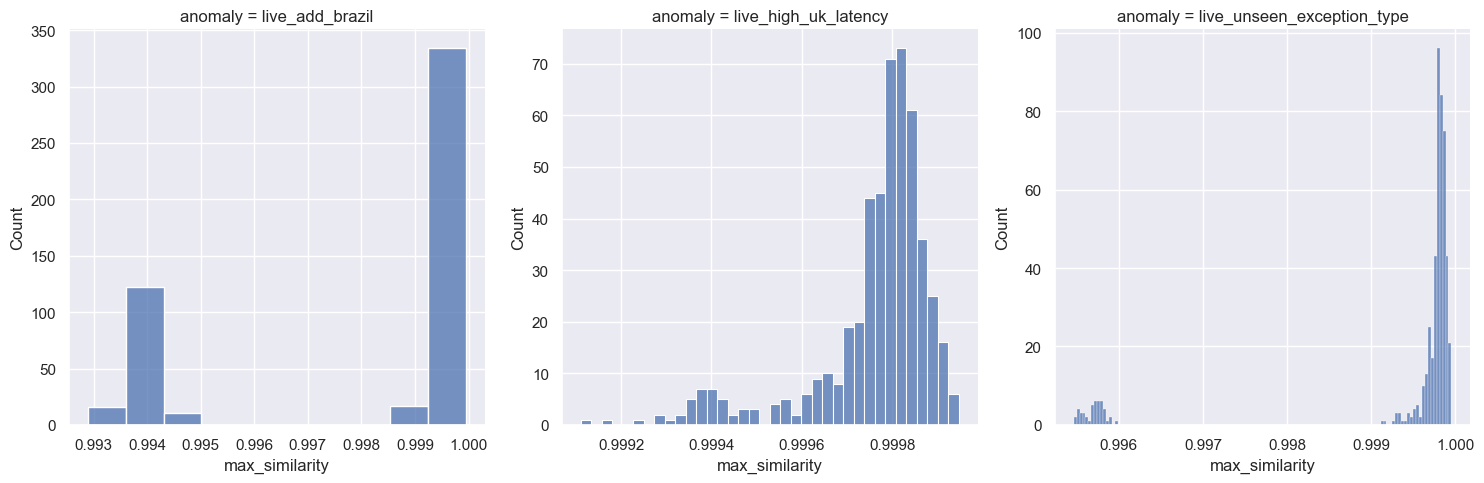

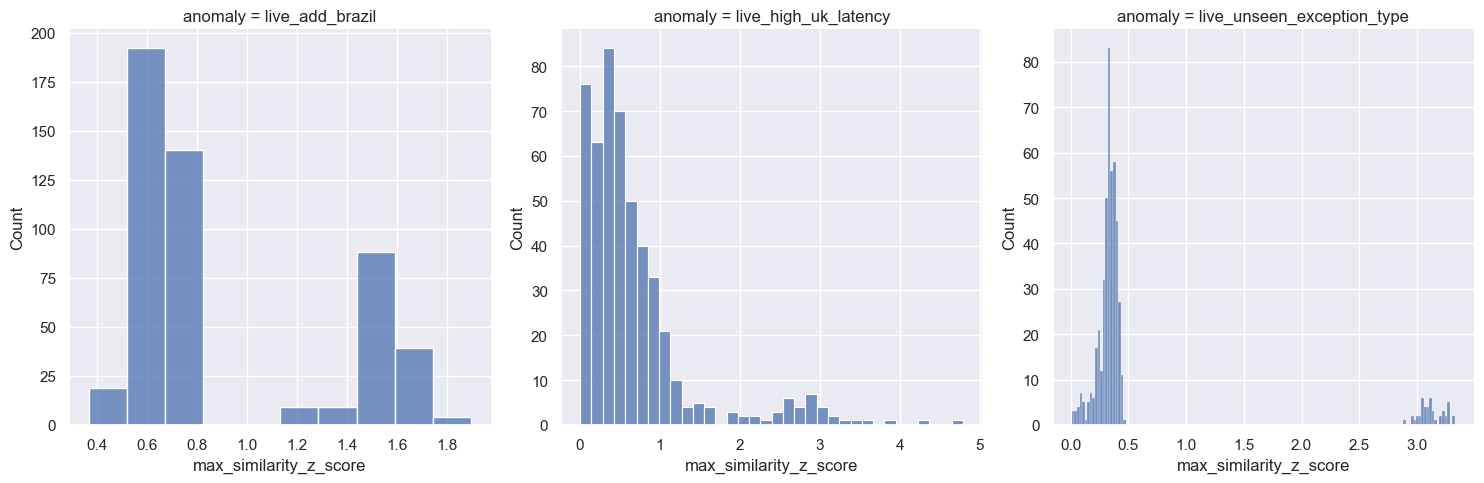

In [197]:
# First, lets plot the distribution of scores for each anomaly.
g = sns.FacetGrid(all_data, col='anomaly',sharey=False, sharex=False, height=5)
g.map(sns.histplot, "max_similarity")

# z-score is the number of standard-deviations away from the mean. Since our values are so close together, we'll say anything above one standard deviation is an anomaly.
g1 = sns.FacetGrid(all_data, col='anomaly',sharey=False, sharex=False, height=5)
g1.map(sns.histplot, 'max_similarity_z_score')

## Anomaly: New user location

<Axes: xlabel='max_similarity', ylabel='Count'>

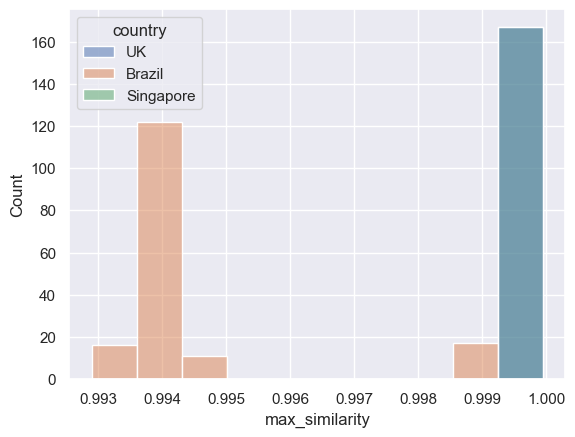

In [198]:
sns.histplot(live_brazil_df, x='max_similarity', hue="country")

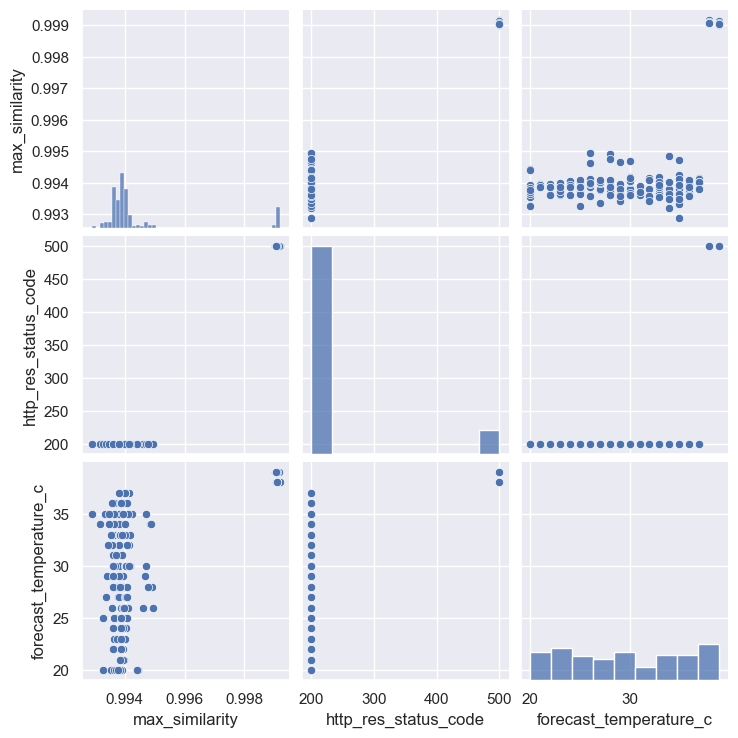

In [199]:
# Let's use a pairplot to figure out why some Brazillian traces look more 'similar' than others
sns.pairplot(live_brazil_df[live_brazil_df['country'] == "Brazil"], vars=['max_similarity', 'http_res_status_code', 'forecast_temperature_c'])

## Anomaly: High request latency for the UK

C:\Users\Blake\AppData\Local\Temp\ipykernel_16964\2227242989.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_uk['max_similarity_z_score'] = [0] * len(baseline_uk)
C:\Users\Blake\AppData\Local\Temp\ipykernel_16964\2227242989.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_uk['dataset'] = ['baseline_uk'] * len(baseline_uk)
C:\Users\Blake\AppData\Local\Temp\ipykernel_16964\2227242989.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

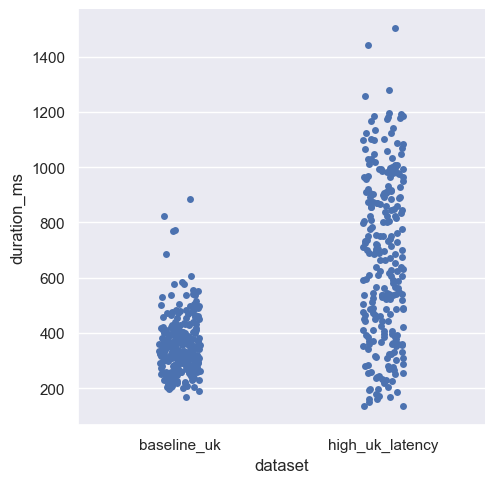

In [200]:
# Lets compare durations between the baseline and the high anomaly dataset 
baseline_uk = baseline_df[baseline_df['country'] == 'UK']
high_latency_uk = live_high_uk_latency_df[live_high_uk_latency_df['country'] == 'UK']

baseline_uk['max_similarity_z_score'] = [0] * len(baseline_uk)
baseline_uk['dataset'] = ['baseline_uk'] * len(baseline_uk)
high_latency_uk['dataset'] = ['high_uk_latency'] * len(high_latency_uk)

combined_latency = pd.concat([baseline_uk, high_latency_uk])
sns.catplot(combined_latency, x='dataset', y='duration_ms')

<Axes: xlabel='max_similarity', ylabel='Count'>

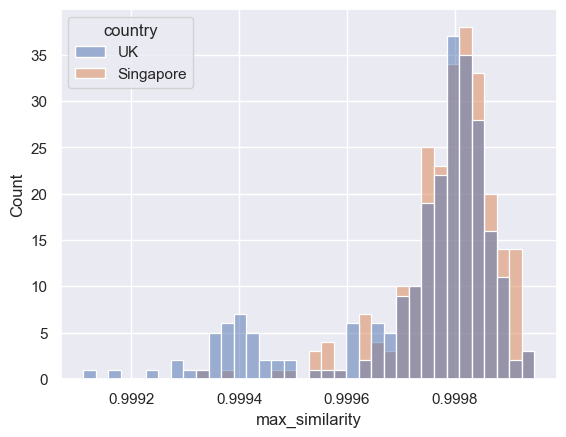

In [201]:
sns.histplot(live_high_uk_latency_df, x='max_similarity', hue='country')

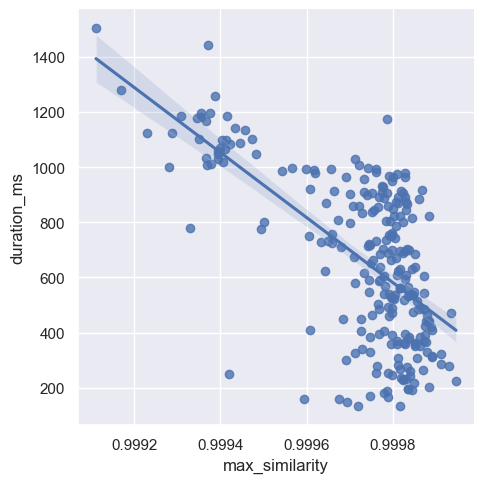

In [202]:
# Rough trend downwards, but noisy and the scores are very close together (within 0.001)
uk_df=live_high_uk_latency_df[live_high_uk_latency_df['country'] == "UK"]
sns.lmplot(uk_df, x='max_similarity', y='duration_ms')

## Anomaly: Unseen exception types

<Axes: xlabel='max_similarity', ylabel='Count'>

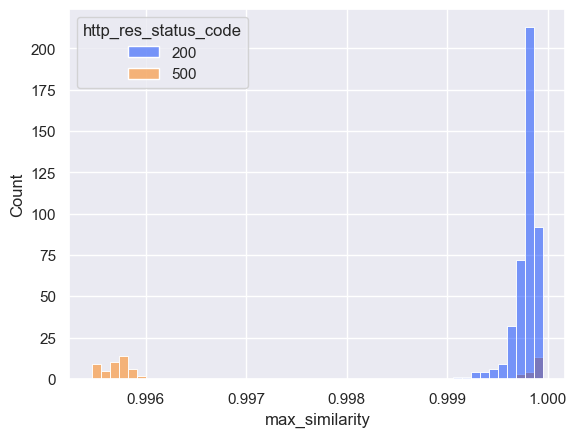

In [203]:
sns.histplot(live_unseen_exception_type_df, x='max_similarity', hue='http_res_status_code', bins=50, palette='bright')

{'System.Collections.Generic.KeyNotFoundException': 0, 'System.InvalidOperationException': 1}


<Axes: xlabel='max_similarity', ylabel='Count'>

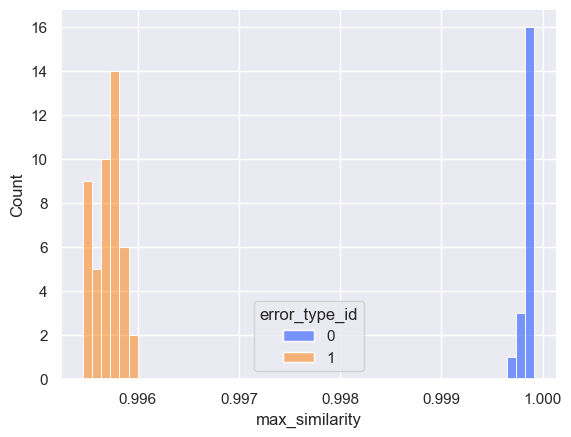

In [204]:
print(error_type_ids)

errors_df=live_unseen_exception_type_df[live_unseen_exception_type_df['http_res_status_code'] == 500]
sns.histplot(errors_df, x='max_similarity', hue='error_type_id', bins=50, palette='bright')